# Covid and Influenza - sick and death cases comparison

**Sources:**
- https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
- https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
- https://flunewseurope.org/VirusCharacteristics



**Terms of Use:**
1.	This data set is licensed under the Creative Commons Attribution 4.0 International (CC BY 4.0) by the Johns Hopkins University on behalf of its Center for Systems Science in Engineering. Copyright Johns Hopkins University 2020.
2.	Attribute the data as the "COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University" or "JHU CSSE COVID-19 Data" for short, and the url: https://github.com/CSSEGISandData/COVID-19.
3.	For publications that use the data, please cite the following publication: "Dong E, Du H, Gardner L. An interactive web-based dashboard to track COVID-19 in real time. Lancet Inf Dis. 20(5):533-534. doi: 10.1016/S1473-3099(20)30120-1"

### Notes:

**Influenza:**
- Add a description - where I found flu reports
- “Influenza virus detections by type in Europe.xlsx”

**Covid:** Use csv files from csse_covid_19_time_series folder
- refresh this report: (https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data) and add README - description

In [1]:
import pandas as pd
import os
from pathlib import Path


from bs4 import BeautifulSoup
import requests
import re 
import io
import numpy as np

In [2]:
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))

In [3]:
directory_flue = os.path.join(BASE_DIR, 'influenza')

# 1. Influenza

----------
Influenza virus detections by type in Europe:

In [4]:
ws = 'Influenza virus detections by type in Europe.xlsx'
flu_detected = pd.read_excel(os.path.join(directory_flue, ws).replace('\\','/'))

In [5]:
flu_detected.head()

,Season,Region,Country,Week,Surveillance System Type,A not subtyped,A(H1)pdm09,A(H3),B lineage not determined,B/Vic,B/Yam
0,2015/2016,EU/EEA,Austria,2015-W40,Non-sentinel,0,0,0,0,0,0
1,2015/2016,EU/EEA,Austria,2015-W44,Non-sentinel,1,0,0,0,0,0
2,2015/2016,EU/EEA,Austria,2015-W46,Non-sentinel,0,3,0,0,0,0
3,2015/2016,EU/EEA,Austria,2015-W47,Non-sentinel,0,3,2,0,0,0
4,2015/2016,EU/EEA,Austria,2015-W48,Non-sentinel,0,2,4,0,0,0


In [6]:
flu_detected['Region'].unique()

array(['EU/EEA', 'WHO Europe'], dtype=object)

In [7]:
flu_detected[(flu_detected.Country=='Poland')&(flu_detected.Week=='2015-W40')]

,Season,Region,Country,Week,Surveillance System Type,A not subtyped,A(H1)pdm09,A(H3),B lineage not determined,B/Vic,B/Yam
657,2015/2016,EU/EEA,Poland,2015-W40,Non-sentinel,1,0,0,0,0,0
1792,2015/2016,WHO Europe,Poland,2015-W40,Non-sentinel,1,0,0,0,0,0


In [8]:
len(flu_detected[(flu_detected.Country=='Poland')&(flu_detected.Region=='EU/EEA')])

291

In [9]:
len(flu_detected[(flu_detected.Country=='Poland')&(flu_detected.Region=='WHO Europe')])

291

In [10]:
flu_detected[(flu_detected.Country=='Poland')&(flu_detected.Region=='WHO Europe')].iloc[:,5:].values.sum()

7690

In [11]:
flu_detected[(flu_detected.Country=='Poland')&(flu_detected.Region=='EU/EEA')].iloc[:,5:].values.sum()

7690

In [12]:
len(flu_detected[flu_detected.Region=='EU/EEA'])

5711

In [13]:
print(f"In EEA we have {len(flu_detected[flu_detected.Region=='EU/EEA'])} records while in WHO Europe we have"
      f" {len(flu_detected[flu_detected.Region=='WHO Europe'])} records")

In EEA we have 5711 records while in WHO Europe we have 9763 records


In [14]:
flu_detected = flu_detected[flu_detected.Region == 'WHO Europe']

In [15]:
flu_detected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9763 entries, 946 to 15473
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Season                    9763 non-null   object
 1   Region                    9763 non-null   object
 2   Country                   9763 non-null   object
 3   Week                      9763 non-null   object
 4   Surveillance System Type  9763 non-null   object
 5   A not subtyped            9763 non-null   int64 
 6   A(H1)pdm09                9763 non-null   int64 
 7   A(H3)                     9763 non-null   int64 
 8   B lineage not determined  9763 non-null   int64 
 9   B/Vic                     9763 non-null   int64 
 10  B/Yam                     9763 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 915.3+ KB


## First conclusion:
- Both tables looks similar
- Change coumn name: YearWeek - Week
- What is "Surveillance System Type" and do we need it?
- Do we need "Season" and "Region" columns? If not then remove them
- Create total cases for flu
- Unpivot the table
- Split YearWeek column into 2 separate

In [16]:
flu_detected.rename(columns={'Week':'YearWeek'},inplace=True)

In [17]:
flu_detected.columns

Index(['Season', 'Region', 'Country', 'YearWeek', 'Surveillance System Type',
       'A not subtyped', 'A(H1)pdm09', 'A(H3)', 'B lineage not determined',
       'B/Vic', 'B/Yam'],
      dtype='object')

In [18]:
flu_detected['Surveillance System Type'].unique()

array(['Non-sentinel'], dtype=object)

In [19]:
flu_detected['Season'].unique()

array(['2015/2016', '2016/2017', '2017/2018', '2018/2019', '2019/2020',
       '2020/2021'], dtype=object)

In [20]:
flu_detected['YearWeek'].unique()[:5]

array(['2016-W03', '2016-W07', '2015-W40', '2015-W44', '2015-W46'],
      dtype=object)

So, I do not need columns "Surveillance System Type" (_one unique value: 'Non-sentinel'_), "Season" (_Week is more precise_) and "Region" (_only 'WHO Europe'_)

-----------
Now I will create 2 functions:
1. Calculate total influenza cases
2. Unpivot a table to keep it simple

In [21]:
# this column is just in one table. So I did not have it in the above function
flu_detected = flu_detected.drop(['Season','Region','Surveillance System Type'],axis=1) 

In [22]:
flu_detected.columns

Index(['Country', 'YearWeek', 'A not subtyped', 'A(H1)pdm09', 'A(H3)',
       'B lineage not determined', 'B/Vic', 'B/Yam'],
      dtype='object')

In [23]:
flu_detected.iloc[:,2:] # we will summarize it from the third column

,A not subtyped,A(H1)pdm09,A(H3),B lineage not determined,B/Vic,B/Yam
946,0,1,0,0,0,0
947,0,0,0,0,5,0
948,0,0,0,0,0,0
949,1,0,0,0,0,0
950,0,3,0,0,0,0
...,...,...,...,...,...,...
15469,0,0,0,0,0,0
15470,0,0,0,0,0,0
15471,0,0,0,0,0,0
15472,0,0,0,0,0,0


In [24]:
flu_detected['Total Detected Cases'] = flu_detected.iloc[:,2:].sum(axis=1).values
flu_detected.head()

,Country,YearWeek,A not subtyped,A(H1)pdm09,A(H3),B lineage not determined,B/Vic,B/Yam,Total Detected Cases
946,Albania,2016-W03,0,1,0,0,0,0,1
947,Albania,2016-W07,0,0,0,0,5,0,5
948,Austria,2015-W40,0,0,0,0,0,0,0
949,Austria,2015-W44,1,0,0,0,0,0,1
950,Austria,2015-W46,0,3,0,0,0,0,3


In [25]:
flu_detected[(flu_detected['Total Detected Cases']>0)&(flu_detected.YearWeek=='2021-W01')]

,Country,YearWeek,A not subtyped,A(H1)pdm09,A(H3),B lineage not determined,B/Vic,B/Yam,Total Detected Cases
13846,Austria,2021-W01,0,0,0,1,1,0,2
14115,Denmark,2021-W01,3,0,0,4,0,0,7
14801,Norway,2021-W01,0,0,0,0,1,0,1
14999,Russian Federation,2021-W01,1,0,1,1,0,0,3
15131,Spain,2021-W01,1,0,0,0,0,0,1
15164,Sweden,2021-W01,0,0,1,0,0,0,1
15197,Switzerland,2021-W01,3,0,0,1,0,0,4
15339,United Kingdom - England,2021-W01,10,0,0,10,0,0,20
15405,United Kingdom - Scotland,2021-W01,0,0,1,2,0,0,3


In [26]:
flu_detected[(flu_detected.Country=='Poland')&(flu_detected.YearWeek=='2016-W04')] # looks ok

,Country,YearWeek,A not subtyped,A(H1)pdm09,A(H3),B lineage not determined,B/Vic,B/Yam,Total Detected Cases
1809,Poland,2016-W04,4,37,0,4,0,0,45


In [27]:
# Unpivot table 
def FluPivot(df,colname):
    x = pd.melt(df, id_vars=['Country', 'YearWeek'], var_name='Flu Type', value_name='Cases').sort_values(['YearWeek','Country'])
    x[['Year', 'Week']] = x['YearWeek'].str.split('-', n=1, expand=True)
    x = x.drop(["YearWeek"],axis=1)
    x.rename(columns={'Cases':colname},inplace=True)
    return x

In [28]:
flu_detected2 = FluPivot(flu_detected,'Detected_Cases')
flu_detected2.head()

,Country,Flu Type,Detected_Cases,Year,Week
2,Austria,A not subtyped,0,2015,W40
9765,Austria,A(H1)pdm09,0,2015,W40
19528,Austria,A(H3),0,2015,W40
29291,Austria,B lineage not determined,0,2015,W40
39054,Austria,B/Vic,0,2015,W40


In [29]:
flu_detected2['Flu Type'].unique()

array(['A not subtyped', 'A(H1)pdm09', 'A(H3)',
       'B lineage not determined', 'B/Vic', 'B/Yam',
       'Total Detected Cases'], dtype=object)

In [30]:
flu_detected2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68341 entries, 2 to 68340
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         68341 non-null  object
 1   Flu Type        68341 non-null  object
 2   Detected_Cases  68341 non-null  int64 
 3   Year            68341 non-null  object
 4   Week            68341 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.1+ MB


In [31]:
flu_detected2[(flu_detected2.Country=='Poland')&(flu_detected2.Year=='2016')\
              &(flu_detected2['Flu Type']=='Total Detected Cases')]['Detected_Cases'].sum() # looks ok

2573

In [32]:
flu_detected2[(flu_detected2.Country=='Poland')&(flu_detected2.Year=='2016')]

,Country,Flu Type,Detected_Cases,Year,Week
860,Poland,A not subtyped,0,2016,W01
10623,Poland,A(H1)pdm09,1,2016,W01
20386,Poland,A(H3),0,2016,W01
30149,Poland,B lineage not determined,0,2016,W01
39912,Poland,B/Vic,0,2016,W01
...,...,...,...,...,...
21968,Poland,A(H3),1,2016,W52
31731,Poland,B lineage not determined,0,2016,W52
41494,Poland,B/Vic,0,2016,W52
51257,Poland,B/Yam,0,2016,W52


In [33]:
# Rename Flu Type names
original_type_names = ['A not subtyped', 'A(H1)pdm09', 'A(H3)',
       'B lineage not determined', 'B/Vic', 'B/Yam']

new_type_names = ['A', 'A(H1)', 'A(H3)','B', 'B/Vic', 'B/Yam']

for o, n in zip(original_type_names,new_type_names):
    flu_detected2.loc[(flu_detected2['Flu Type'] == o),'Flu Type']=n

In [34]:
flu_detected2.head()

,Country,Flu Type,Detected_Cases,Year,Week
2,Austria,A,0,2015,W40
9765,Austria,A(H1),0,2015,W40
19528,Austria,A(H3),0,2015,W40
29291,Austria,B,0,2015,W40
39054,Austria,B/Vic,0,2015,W40


In [35]:
import matplotlib.pyplot as plt

In [36]:
for year in (flu_detected2.Year.unique()):
    print(year)

2015
2016
2017
2018
2019
2020
2021


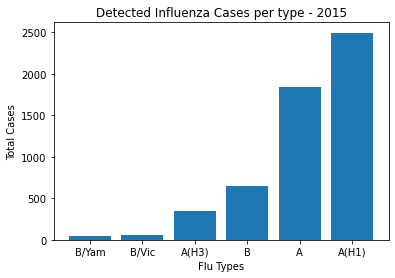

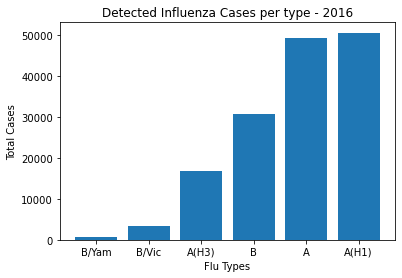

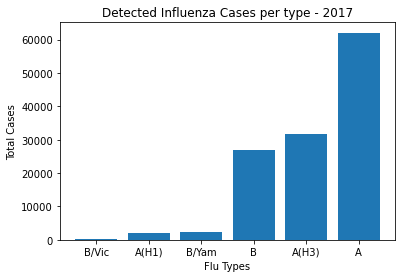

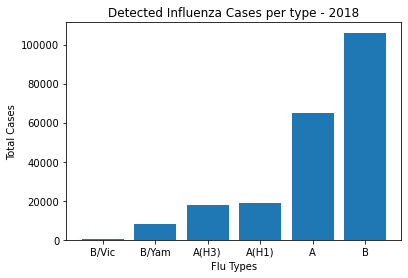

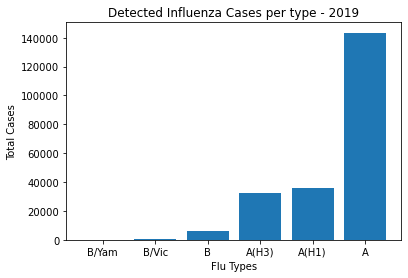

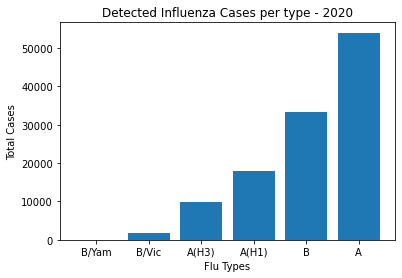

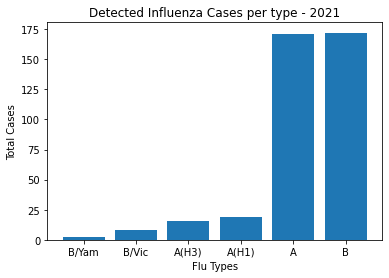

In [37]:
for year in (flu_detected2.Year.unique()):
    fd2 = flu_detected2[(flu_detected2.Year==year)&(flu_detected2['Flu Type']!='Total Detected Cases')].groupby(['Flu Type'])['Detected_Cases'].sum().sort_values().reset_index()

    fig, ax = plt.subplots()
    types = fd2['Flu Type']
    cases = fd2.Detected_Cases
    result = ax.bar(types,cases)

    ax.set_ylabel('Total Cases')
    ax.set_xlabel('Flu Types')
    ax.set_title(f'Detected Influenza Cases per type - {year}')

    plt.show()

In [38]:
# Amount od total cases
flu_detected2[(flu_detected2['Flu Type']=='Total Detected Cases')].sort_values(['Year']).groupby(['Flu Type','Year'])\
['Detected_Cases'].sum().reset_index()

,Flu Type,Year,Detected_Cases
0,Total Detected Cases,2015,5433
1,Total Detected Cases,2016,151914
2,Total Detected Cases,2017,125321
3,Total Detected Cases,2018,215683
4,Total Detected Cases,2019,217645
5,Total Detected Cases,2020,116834
6,Total Detected Cases,2021,388


In [39]:
# Amount of records
flu_detected2[(flu_detected2['Flu Type']=='Total Detected Cases')].groupby('Year')['Flu Type'].count()

Year
2015     406
2016    1645
2017    1637
2018    1731
2019    1677
2020    1707
2021     960
Name: Flu Type, dtype: int64

In [40]:
years = flu_detected2.Year.unique()
for year in years:
    print(f'In {year} we have {len(flu_detected2[flu_detected2.Year==year].Week.unique())} weeks')

In 2015 we have 14 weeks
In 2016 we have 52 weeks
In 2017 we have 52 weeks
In 2018 we have 52 weeks
In 2019 we have 52 weeks
In 2020 we have 53 weeks
In 2021 we have 19 weeks


In [41]:
# remove unnecesary weeks
# flu_detected2 = flu_detected2[flu_detected2.Year!='2015']
years_list = ['2016','2017','2018','2019','2020', '2021'] # we keep 2021 as covid data are available for this year
flu_detected2 = flu_detected2[flu_detected2['Year'].isin(years_list)]

In [42]:
flu_detected2[(flu_detected2.Country=='Poland')&(flu_detected2['Flu Type']=='Total Detected Cases')].sort_values(['Year'])\
.groupby(['Flu Type','Year'])['Detected_Cases'].sum().reset_index()

,Flu Type,Year,Detected_Cases
0,Total Detected Cases,2016,2573
1,Total Detected Cases,2017,982
2,Total Detected Cases,2018,1678
3,Total Detected Cases,2019,1441
4,Total Detected Cases,2020,995
5,Total Detected Cases,2021,0


In [49]:
df_flu = flu_detected2[(flu_detected2['Flu Type']=='Total Detected Cases')].sort_values(['Year'])\
.groupby(['Country','Year', 'Week'])['Detected_Cases'].sum().reset_index()

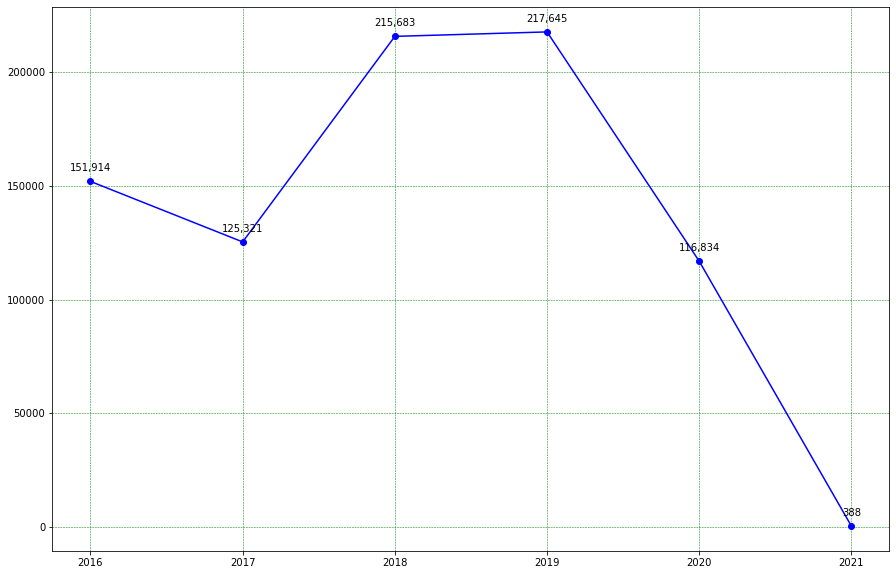

In [55]:
xs = df_flu.groupby('Year')['Detected_Cases'].sum().reset_index()['Year']
ys = df_flu.groupby('Year')['Detected_Cases'].sum().reset_index().Detected_Cases.values

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(xs,ys,'bo-')

for x,y in zip(xs,ys):

    #label = "{:.0f}".format(y)
    label = f'{y:,}'
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

plt.show()

In [56]:
df_flu

,Country,Year,Week,Detected_Cases
0,Albania,2016,W03,1
1,Albania,2016,W07,5
2,Albania,2017,W43,0
3,Albania,2017,W44,0
4,Albania,2018,W02,1
...,...,...,...,...
9352,Uzbekistan,2021,W15,0
9353,Uzbekistan,2021,W16,0
9354,Uzbekistan,2021,W17,0
9355,Uzbekistan,2021,W18,0


In [57]:
df_flu['Week'] = df_flu['Week'].map(lambda x: x.lstrip('W'))
df_flu['Week'] = df_flu['Week'].astype('int')
df_flu['Year'] = df_flu['Year'].astype('int')

In [58]:
df_flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         9357 non-null   object
 1   Year            9357 non-null   int32 
 2   Week            9357 non-null   int32 
 3   Detected_Cases  9357 non-null   int64 
dtypes: int32(2), int64(1), object(1)
memory usage: 219.4+ KB


In [59]:
df_flu.sort_values(['Year','Week']).head(10)

,Country,Year,Week,Detected_Cases
81,Austria,2016,1,38
215,Azerbaijan,2016,1,9
396,Belarus,2016,1,5
673,Bulgaria,2016,1,3
787,Croatia,2016,1,7
1007,Czechia,2016,1,1
1179,Denmark,2016,1,30
1457,Estonia,2016,1,6
1696,Finland,2016,1,5
1976,France,2016,1,75


In [61]:
df_flu[(df_flu.Country=='Poland')].sort_values(['Year'])\
.groupby(['Year'])['Detected_Cases'].sum().reset_index()

,Year,Detected_Cases
0,2016,2573
1,2017,982
2,2018,1678
3,2019,1441
4,2020,995
5,2021,0


-----
## Import Covid tables down below

## [Daily reports (csse_covid_19_daily_reports)](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports)

This folder contains daily case reports. All timestamps are in UTC (GMT+0).

### File naming convention
MM-DD-YYYY.csv in UTC.

### Field description
* <b>FIPS</b>: US only. Federal Information Processing Standards code that uniquely identifies counties within the USA.
* <b>Admin2</b>: County name. US only.
* <b>Province_State</b>: Province, state or dependency name.
* <b>Country_Region</b>: Country, region or sovereignty name. The names of locations included on the Website correspond with the official designations used by the U.S. Department of State.
* <b>Last Update</b>: MM/DD/YYYY HH:mm:ss  (24 hour format, in UTC).
* <b>Lat</b> and <b>Long_</b>: Dot locations on the dashboard. All points (except for Australia) shown on the map are based on geographic centroids, and are not representative of a specific address, building or any location at a spatial scale finer than a province/state. Australian dots are located at the centroid of the largest city in each state.
* <b>Confirmed</b>: Counts include confirmed and probable (where reported).
* <b>Deaths</b>: Counts include confirmed and probable (where reported).
* <b>Recovered</b>: Recovered cases are estimates based on local media reports, and state and local reporting when available, and therefore may be substantially lower than the true number. US state-level recovered cases are from [COVID Tracking Project](https://covidtracking.com/).
* <b>Active:</b> Active cases = total cases - total recovered - total deaths.
* <b>Incident_Rate</b>: Incidence Rate = cases per 100,000 persons.
* <b>Case_Fatality_Ratio (%)</b>: Case-Fatality Ratio (%) = Number recorded deaths / Number cases.
* All cases, deaths, and recoveries reported are based on the date of initial report. Exceptions to this are noted in the "Data Modification" and "Retrospective reporting of (probable) cases and deaths" subsections below.  


What do we need:

* <b>Country_Region</b>: Country, region or sovereignty name. The names of locations included on the Website correspond with the official designations used by the U.S. Department of State.
* <b>Last Update</b>: MM/DD/YYYY HH:mm:ss  (24 hour format, in UTC).
* <b>Lat</b> and <b>Long_</b>: Dot locations on the dashboard. All points (except for Australia) shown on the map are based on geographic centroids, and are not representative of a specific address, building or any location at a spatial scale finer than a province/state. Australian dots are located at the centroid of the largest city in each state.
* <b>Confirmed</b>: Counts include confirmed and probable (where reported).
* <b>Deaths</b>: Counts include confirmed and probable (where reported).
* <b>Recovered</b>: Recovered cases are estimates based on local media reports, and state and local reporting when available, and therefore may be substantially lower than the true number. US state-level recovered cases are from [COVID Tracking Project](https://covidtracking.com/).
* <b>Active:</b> Active cases = total cases - total recovered - total deaths.
* <b>Incident_Rate</b>: Incidence Rate = cases per 100,000 persons.
* <b>Case_Fatality_Ratio (%)</b>: Case-Fatality Ratio (%) = Number recorded deaths / Number cases.
* All cases, deaths, and recoveries reported are based on the date of initial report. Exceptions to this are noted in the "Data Modification" and "Retrospective reporting of (probable) cases and deaths" subsections below.  


In [ ]:
url = "https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports"
r = requests.get(url)

In [ ]:
html_doc = r.text
soup = BeautifulSoup(html_doc)
a_tags = soup.find_all('a')

# Store a list of urls ending in .csv: urls => list
urls = ['https://raw.githubusercontent.com'+re.sub('/blob', '', link.get('href'))
        for link in a_tags  if '.csv' in link.get('href')]

# Store a list of Data Frame names to be assigned to the list: df_list_names => list
df_list_names = [url.split('.csv')[0].split('/')[url.count('/')] for url in urls]

In [ ]:
urls[:5]

In [ ]:
df_list_names[:5]

In [ ]:
comments = pd.DataFrame(columns=['File_Name','Added','Not_Added'])
comments.head()

In [ ]:
len(urls)

In [ ]:
cols = ['Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','File_Name']

covid_table = pd.DataFrame(columns = cols)
covid_table.head()

In [ ]:
def Add_Comment(url_name, is_ok, is_not_ok):
    data = [[url_name,is_ok,is_not_ok]]
    comment_note = pd.DataFrame(data, columns = ['File_Name','Added','Not_Added'])
    return comment_note

In [ ]:
# some tables have a bit different column names, if so then I keep only the below names
col_names1 = ['Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered']
col_names2 = ['Country/Region','Last Update','Latitude','Longitude','Confirmed','Deaths','Recovered']
col_names3 = ['Country/Region','Last Update','Confirmed','Deaths','Recovered']

In [ ]:
url

In [ ]:
for count, url in enumerate(urls):
    download = requests.get(url).content
    # Reading the downloaded content and turning it into a pandas dataframe
    df = pd.read_csv(io.StringIO(download.decode('utf-8')))
    if (df.shape[1] == 14) | (df.shape[1] == 12):
        df = df[col_names1]
    elif df.shape[1] == 8:
        df = df[col_names2]
    elif df.shape[1] == 6:
        df = df[col_names3]
        df['Lat'] = 0
        df['Long_'] = 0
        df = df[['Country/Region','Last Update','Lat','Long_','Confirmed','Deaths','Recovered']]
    else:
        print(f'We have {df.shape[1]} columns in {url} file')
    
    df['File_Name'] = df_list_names[count]        
    try:
        df.columns = cols # renaming the columns
        covid_table = covid_table.append(df, ignore_index=True)
        comment = Add_Comment(df_list_names[count], 1, 0)
        comments = comments.append(comment, ignore_index=True)
    except:
        comment = Add_Comment(df_list_names[count], 0, 1)
        comments = comments.append(comment, ignore_index=True)
        pass

In [ ]:
df.head()

In [ ]:
covid_table.head()

In [ ]:
covid_table.info()

In [ ]:
comments[['Added','Not_Added']].sum().plot(kind='bar')

## Save the file
to safe my time for loading data from the internet

In [ ]:
covid_table.to_csv('covid_summary.csv',index=False)

In [ ]:
df_covid = pd.read_csv('covid_summary.csv')
# df_covid = covid_table.copy()

## Covid Table Analyzing

In [62]:
df_covid = pd.read_csv('covid_summary.csv')

In [63]:
df_covid['File_Name'] = pd.to_datetime(df_covid['File_Name']).dt.date
df_covid['Last_Update'] = pd.to_datetime(df_covid['Last_Update']).dt.date

In [64]:
df_covid.fillna({'Deaths':0,'Confirmed':0,'Recovered':0},inplace=True)

In [65]:
covid_cases_list = ['Confirmed','Deaths','Recovered']
for case in covid_cases_list:
    df_covid[case] = df_covid[case].astype(float)

In [66]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1645514 entries, 0 to 1645513
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Country_Region  1645514 non-null  object 
 1   Last_Update     1645514 non-null  object 
 2   Lat             1611454 non-null  float64
 3   Long_           1611454 non-null  float64
 4   Confirmed       1645514 non-null  float64
 5   Deaths          1645514 non-null  float64
 6   Recovered       1645514 non-null  float64
 7   File_Name       1645514 non-null  object 
dtypes: float64(5), object(3)
memory usage: 100.4+ MB


In [67]:
df_covid.head()

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,File_Name
0,Afghanistan,2021-01-02,33.93911,67.709953,51526.0,2191.0,41727.0,2021-01-01
1,Albania,2021-01-02,41.15330,20.168300,58316.0,1181.0,33634.0,2021-01-01
2,Algeria,2021-01-02,28.03390,1.659600,99897.0,2762.0,67395.0,2021-01-01
3,Andorra,2021-01-02,42.50630,1.521800,8117.0,84.0,7463.0,2021-01-01
4,Angola,2021-01-02,-11.20270,17.873900,17568.0,405.0,11146.0,2021-01-01


In [68]:
df_covid = df_covid.groupby(['Country_Region','Last_Update']).agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

In [69]:
df_covid.head()

,Country_Region,Last_Update,Confirmed,Deaths,Recovered
0,Azerbaijan,2020-02-28,1.0,0.0,0.0
1,Afghanistan,2020-02-24,26.0,0.0,0.0
2,Afghanistan,2020-03-08,12.0,0.0,0.0
3,Afghanistan,2020-03-10,8.0,0.0,0.0
4,Afghanistan,2020-03-11,36.0,0.0,0.0


In [70]:
# getting week/year as numbers
week_no = []
year_no = []
for value in df_covid['Last_Update']:
    week_no.append(value.isocalendar()[1])
    year_no.append(value.isocalendar()[0])

df_covid['Week'] = week_no
df_covid['Year'] = year_no

In [71]:
df_covid[(df_covid.Country_Region=='Germany')&(df_covid.Week==21)&(df_covid.Year==2021)]

,Country_Region,Last_Update,Confirmed,Deaths,Recovered,Week,Year
29440,Germany,2021-05-24,3657662.0,87429.0,3410040.0,21,2021
29441,Germany,2021-05-25,3659990.0,87461.0,3425380.0,21,2021


In [72]:
df_covid = df_covid.groupby(['Country_Region','Week','Year'], sort=False).agg({'Confirmed':'max','Deaths':'max','Recovered':'max'}).reset_index()

In [73]:
df_covid[(df_covid.Country_Region=='Germany')&(df_covid.Week==20)&(df_covid.Year==2021)]

,Country_Region,Week,Year,Confirmed,Deaths,Recovered
4362,Germany,20,2021,3653019.0,87385.0,3398700.0


In [74]:
df_covid[(df_covid.Country_Region=='Poland')]['Confirmed'].max()

2866181.0

In [75]:
df_covid.Year.unique()

array([2020, 2021], dtype=int64)

## Comparison

In [76]:
df_covid.rename(columns={'Country_Region':'Country'},inplace=True)

In [77]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12389 entries, 0 to 12388
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    12389 non-null  object 
 1   Week       12389 non-null  int64  
 2   Year       12389 non-null  int64  
 3   Confirmed  12389 non-null  float64
 4   Deaths     12389 non-null  float64
 5   Recovered  12389 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 580.9+ KB


In [78]:
df_flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         9357 non-null   object
 1   Year            9357 non-null   int32 
 2   Week            9357 non-null   int32 
 3   Detected_Cases  9357 non-null   int64 
dtypes: int32(2), int64(1), object(1)
memory usage: 219.4+ KB


In [79]:
df_covid.head()

,Country,Week,Year,Confirmed,Deaths,Recovered
0,Azerbaijan,9,2020,1.0,0.0,0.0
1,Afghanistan,9,2020,26.0,0.0,0.0
2,Afghanistan,10,2020,12.0,0.0,0.0
3,Afghanistan,11,2020,36.0,0.0,0.0
4,Afghanistan,12,2020,69.0,1.0,3.0


In [80]:
df_flu.head()

,Country,Year,Week,Detected_Cases
0,Albania,2016,3,1
1,Albania,2016,7,5
2,Albania,2017,43,0
3,Albania,2017,44,0
4,Albania,2018,2,1


In [81]:
flu_countries = df_flu[['Country']].drop_duplicates()
flu_countries['flu'] = 1
cov_countries = df_covid[['Country']].drop_duplicates()
cov_countries['cov'] = 1

In [82]:
countries = pd.merge(flu_countries,cov_countries,on='Country',how='outer')

In [83]:
countries[countries['cov'].isnull()]

,Country,flu,cov
6,Bosnia And Herzegovina,1.0,NaN
24,Kosovo*,1.0,NaN
35,Republic Of Moldova,1.0,NaN
36,Republic Of North Macedonia,1.0,NaN
47,Turkmenistan,1.0,NaN
49,United Kingdom - England,1.0,NaN
50,United Kingdom - North Ireland,1.0,NaN
51,United Kingdom - Scotland,1.0,NaN
52,United Kingdom - Wales,1.0,NaN


----
Now we can see countries names which are different in both tables. I am going to change them 

In [84]:
missing_countries = ['Herzego','Koso','Mold','Mace','Turkm','Kingdom']
print('Covid:')
for c in missing_countries:
    print(df_covid[df_covid.Country.str.contains(c)].Country.unique()) #flu_df2
    
print('\nInfluenza:')
for c in missing_countries:
    print(df_flu[df_flu.Country.str.contains(c)].Country.unique()) #flu_df2

Covid:
['Bosnia and Herzegovina']
['Kosovo']
['Moldova' 'Republic of Moldova']
['North Macedonia']
[]
['United Kingdom']

Influenza:
['Bosnia And Herzegovina']
['Kosovo*']
['Republic Of Moldova']
['Republic Of North Macedonia']
['Turkmenistan']
['United Kingdom - England' 'United Kingdom - North Ireland'
 'United Kingdom - Scotland' 'United Kingdom - Wales']


In [85]:
missing_countries = ['Herzego','Koso','Mold','Mace','Kingdom', 'Rus']
new_countries = ['Bosnia and Herzegovina','Kosovo','Moldova','Macedonia','United Kingdom', 'Russia'] 

for old,new in zip(missing_countries,new_countries):
    df_covid.loc[df_covid.Country.str.contains(old), 'Country'] = new
    df_flu.loc[df_flu.Country.str.contains(old), 'Country'] = new

In [86]:
print('Covid:')
for c in missing_countries:
    print(df_covid[df_covid.Country.str.contains(c)].Country.unique()) #flu_df2
    
print('\nInfluenza:')
for c in missing_countries:
    print(df_flu[df_flu.Country.str.contains(c)].Country.unique()) #flu_df2

Covid:
['Bosnia and Herzegovina']
['Kosovo']
['Moldova']
['Macedonia']
['United Kingdom']
['Russia']

Influenza:
['Bosnia and Herzegovina']
['Kosovo']
['Moldova']
['Macedonia']
['United Kingdom']
['Russia']


Now the coutries names are the same (Turkmenistan is missing in Covid table)

In [87]:
df_covid.head()

,Country,Week,Year,Confirmed,Deaths,Recovered
0,Azerbaijan,9,2020,1.0,0.0,0.0
1,Afghanistan,9,2020,26.0,0.0,0.0
2,Afghanistan,10,2020,12.0,0.0,0.0
3,Afghanistan,11,2020,36.0,0.0,0.0
4,Afghanistan,12,2020,69.0,1.0,3.0


In [88]:
df_covid.shape

(12389, 6)

In [89]:
df_flu.rename(columns={'Detected_Cases':'Detected_FluCases'},inplace=True)

In [90]:
df_flu.head()

,Country,Year,Week,Detected_FluCases
0,Albania,2016,3,1
1,Albania,2016,7,5
2,Albania,2017,43,0
3,Albania,2017,44,0
4,Albania,2018,2,1


In [91]:
df_flu.shape

(9357, 4)

In [92]:
final_df = pd.merge(df_covid,df_flu,on=['Country','Year','Week'],how='right').sort_values(['Year','Week','Country'])

In [93]:
final_df.shape

(9359, 7)

In [94]:
final_df.head()

,Country,Week,Year,Confirmed,Deaths,Recovered,Detected_FluCases
81,Austria,1,2016,NaN,NaN,NaN,38
215,Azerbaijan,1,2016,NaN,NaN,NaN,9
396,Belarus,1,2016,NaN,NaN,NaN,5
673,Bulgaria,1,2016,NaN,NaN,NaN,3
787,Croatia,1,2016,NaN,NaN,NaN,7


In [95]:
final_df[(final_df.Year==2021) & (final_df.Confirmed.isnull())]

,Country,Week,Year,Confirmed,Deaths,Recovered,Detected_FluCases
8057,Turkmenistan,1,2021,NaN,NaN,NaN,0
8058,Turkmenistan,2,2021,NaN,NaN,NaN,0


Seems everything is ok so we can change NaN into 0 for covid

In [96]:
final_df.fillna({'Deaths':0,'Confirmed':0,'Recovered':0},inplace=True)

In [97]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9359 entries, 81 to 9358
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            9359 non-null   object 
 1   Week               9359 non-null   int64  
 2   Year               9359 non-null   int64  
 3   Confirmed          9359 non-null   float64
 4   Deaths             9359 non-null   float64
 5   Recovered          9359 non-null   float64
 6   Detected_FluCases  9359 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 584.9+ KB


In [98]:
final_df.describe()

,Week,Year,Confirmed,Deaths,Recovered,Detected_FluCases
count,9359.000000,9359.000000,9.359000e+03,9359.000000,9.359000e+03,9359.000000
mean,23.914521,2018.325676,1.363787e+05,3590.474410,5.874108e+04,88.585639
std,16.913302,1.613993,5.579842e+05,14632.529104,3.045605e+05,291.256140
min,1.000000,2016.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,9.000000,2017.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
50%,19.000000,2018.000000,0.000000e+00,0.000000,0.000000e+00,2.000000
75%,42.000000,2020.000000,0.000000e+00,0.000000,0.000000e+00,31.000000
max,53.000000,2021.000000,5.925071e+06,127937.000000,4.495406e+06,4341.000000


In [99]:
final_df.Week.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53], dtype=int64)

In [100]:
quarters = pd.DataFrame(columns={"Week","Quarter"})
def quarter(x): 
    if (x <= 13):
        return 1
    elif (x <= 26):
        return 2
    elif (x <= 39):
        return 3
    else:
        return 4

quarters['Week'] = final_df.Week.unique()
quarters['Quarter'] = quarters['Week'].apply(quarter)

In [101]:
final_df = final_df.merge(quarters,on='Week',how='inner')

In [102]:
final_df.shape

(9359, 8)

In [103]:
final_df.columns

Index(['Country', 'Week', 'Year', 'Confirmed', 'Deaths', 'Recovered',
       'Detected_FluCases', 'Quarter'],
      dtype='object')

In [104]:
final_df.Quarter.unique()

array([1, 2, 3, 4], dtype=int64)

In [105]:
final_df[(final_df.Detected_FluCases>0)&(final_df.Year==2021)].sort_values('Detected_FluCases',ascending=False)

,Country,Week,Year,Confirmed,Deaths,Recovered,Detected_FluCases,Quarter
1943,United Kingdom,7,2021,4117743.0,120593.0,11297.0,20,1
273,United Kingdom,1,2021,3026346.0,81000.0,6855.0,20,1
1387,United Kingdom,5,2021,3941277.0,112305.0,10186.0,17,1
4858,United Kingdom,19,2021,4464663.0,127937.0,15254.0,14,2
4249,United Kingdom,16,2021,4418710.0,127670.0,14388.0,14,2
...,...,...,...,...,...,...,...,...
1111,United Kingdom,4,2021,3806997.0,105777.0,9584.0,1,1
3530,United Kingdom,13,2021,4371389.0,127068.0,13218.0,1,1
3771,Sweden,14,2021,857401.0,13621.0,0.0,1,2
2454,Germany,9,2021,2502151.0,71951.0,2308094.0,1,1


In [106]:
final_df[(final_df.Country=='Poland')]['Confirmed'].max()

2851911.0

In [110]:
final_df.loc[(final_df.Country=='Poland'),('Country', 'Year', 'Confirmed', 'Deaths', 'Recovered',
       'Detected_FluCases', 'Quarter')].groupby(['Year','Quarter']).agg({'Confirmed':'max', 'Deaths':'max', 'Recovered':'max',
       'Detected_FluCases':'sum'}).sort_values(['Year','Quarter']).reset_index().head(4)

,Year,Quarter,Confirmed,Deaths,Recovered,Detected_FluCases
0,2016,1,0.0,0.0,0.0,2377
1,2016,2,0.0,0.0,0.0,158
2,2016,3,0.0,0.0,0.0,10
3,2016,4,0.0,0.0,0.0,28


In [ ]:
# final_df_grouped = final_df[['Country', 'Year', 'Confirmed', 'Deaths', 'Recovered',
#        'Detected_FluCases', 'Quarter']].groupby(['Year','Quarter']).sum().sort_values(['Year','Quarter']).reset_index()

In [114]:
def CovidCasesDevider(df):
    covid_cases_list_mln = ['Confirmed_(mln)','Deaths_(mln)','Recovered_(mln)']
    for case, case_mln in zip(covid_cases_list,covid_cases_list_mln):
        df.rename(columns={case:case_mln},inplace=True)
    
    for col in covid_cases_list_mln:
        for value in range(len(df)):
            df.loc[value,(col)] = df.loc[value,(col)] / 1000000
    return df

In [130]:
final_df_quarter = final_df[['Country', 'Year', 'Confirmed', 'Deaths', 'Recovered',
       'Detected_FluCases', 'Quarter']].groupby(['Country','Year','Quarter']).agg({'Confirmed':'max', 'Deaths':'max', 'Recovered':'max',
       'Detected_FluCases':'sum'}).sort_values(['Country','Year','Quarter']).reset_index()

In [132]:
final_df_quarter[final_df_quarter.Country=='Poland']

,Country,Year,Quarter,Confirmed,Deaths,Recovered,Detected_FluCases
569,Poland,2016,1,0.0,0.0,0.0,2377
570,Poland,2016,2,0.0,0.0,0.0,158
571,Poland,2016,3,0.0,0.0,0.0,10
572,Poland,2016,4,0.0,0.0,0.0,28
573,Poland,2017,1,0.0,0.0,0.0,944
574,Poland,2017,2,0.0,0.0,0.0,4
575,Poland,2017,3,0.0,0.0,0.0,1
576,Poland,2017,4,0.0,0.0,0.0,33
577,Poland,2018,1,0.0,0.0,0.0,1554
578,Poland,2018,2,0.0,0.0,0.0,117


In [197]:
final_df_grouped = final_df_quarter.groupby(['Year','Quarter']).agg({'Confirmed':'sum', 'Deaths':'sum', 'Recovered':'sum',
       'Detected_FluCases':'sum'}).sort_values(['Year','Quarter']).reset_index()

In [198]:
final_df_grouped = CovidCasesDevider(final_df_grouped)

In [199]:
final_df_grouped.tail(4)

,Year,Quarter,Confirmed_(mln),Deaths_(mln),Recovered_(mln),Detected_FluCases
18,2020,3,3.219257,0.155972,1.707565,30
19,2020,4,27.767411,0.587637,14.976806,469
20,2021,1,45.922689,0.979964,25.727631,294
21,2021,2,52.285204,1.097960,30.258658,94


### in the covid_df table we need to rename countries from this list: countries[countries['cov'].isnull()] 

### Dodaj ponizej porownanie

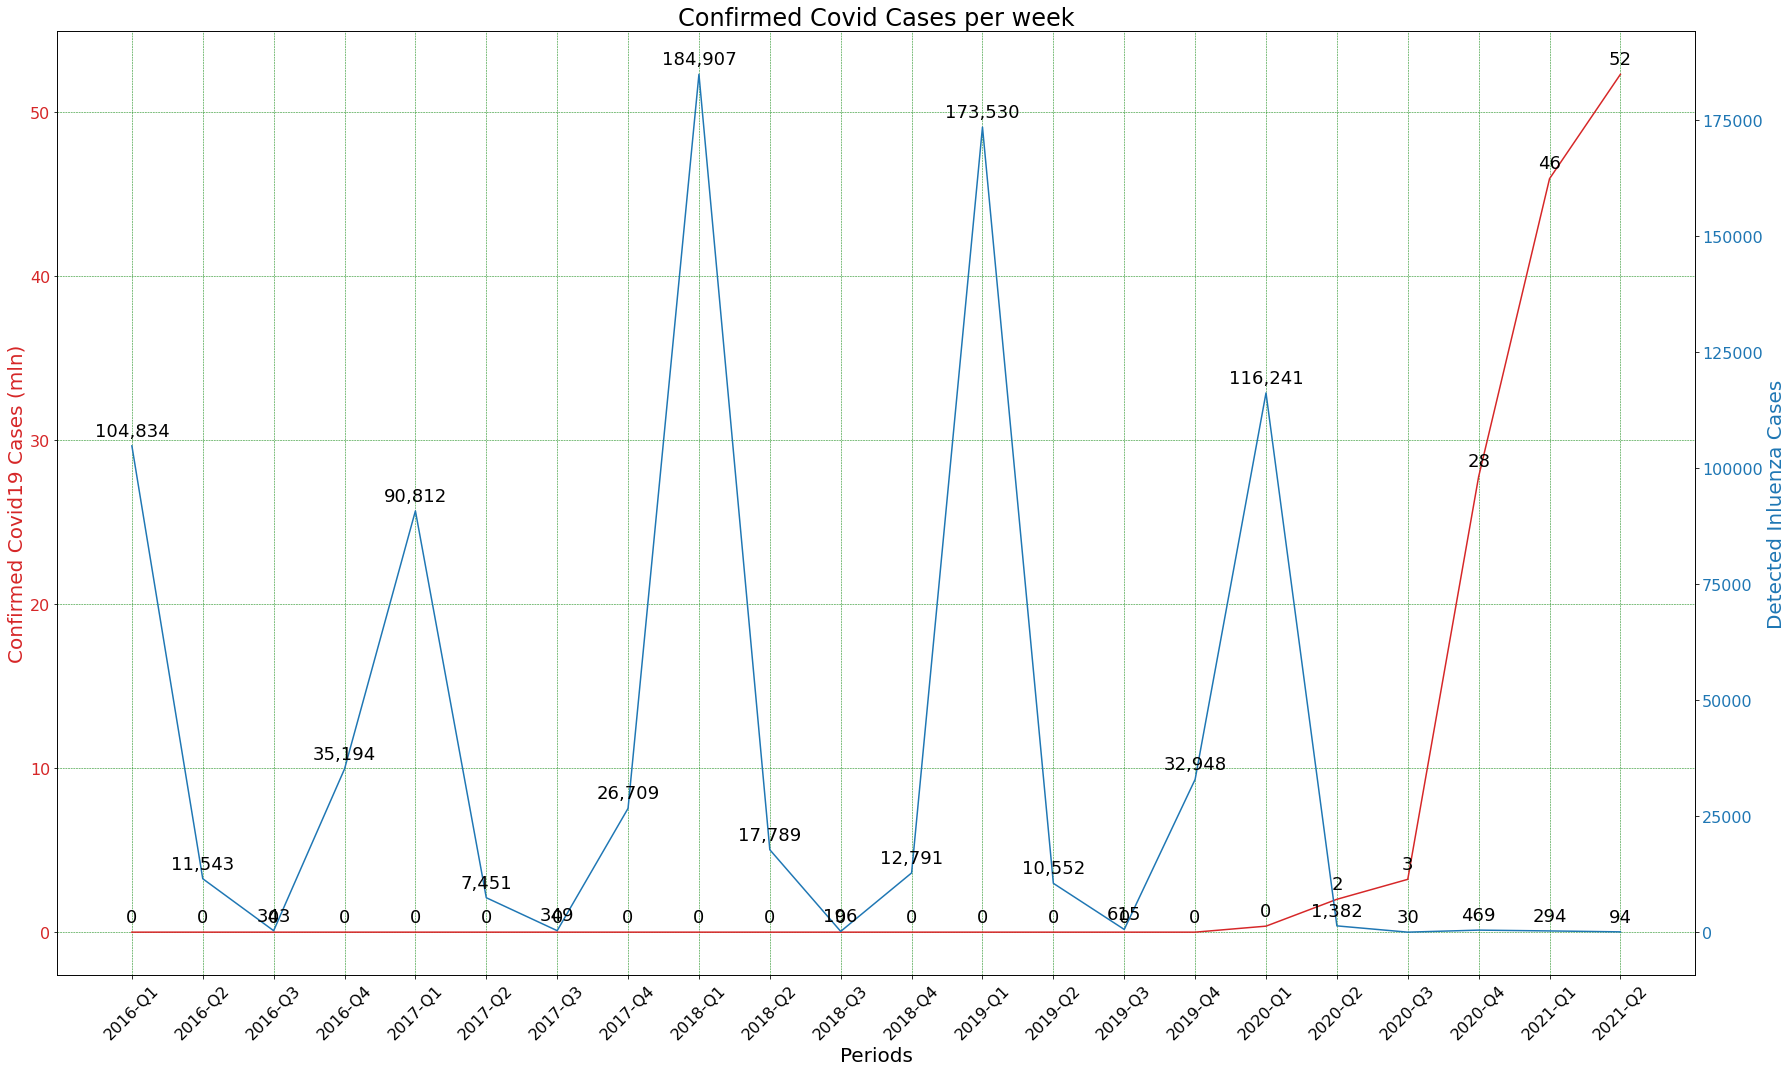

In [212]:
chart = final_df_grouped.copy()
chart['YearQuater'] = chart.Year.astype(str)+'-Q'+chart.Quarter.astype(str)
chart = chart.drop(["Year","Quarter"],axis=1)

fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = (25,15)
plt.xticks(fontsize=16, rotation=45)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

y = chart['Confirmed_(mln)']
x = chart.YearQuater.unique()
z = chart.Detected_FluCases

ax1.set_title(f'Confirmed Covid Cases per week', fontsize=24)

color = 'tab:red'
ax1.set_xlabel('Periods', fontsize=20)
ax1.set_ylabel('Confirmed Covid19 Cases (mln)', color=color, fontsize=20)
ax1.plot(x, y, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize = 16)

for xx,yy in zip(x,y):
    label = "{:.0f}".format(yy)
    plt.annotate(label, (xx,yy), textcoords="offset points", xytext=(0,10), ha='center',fontsize=18) 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Detected Inluenza Cases', color=color, fontsize=20)  # we already handled the x-label with ax1
ax2.plot(x, z, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)

for xx,zz in zip(x,z):
    #label = round(zz, 2)
    label = f'{round(zz, 0):,}'
    plt.annotate(label,(xx,zz),textcoords="offset points",xytext=(0,10),ha='center',fontsize=18)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Per country

In [149]:
chosen_country = 'Poland'

In [156]:
final_df_grouped_country = final_df_quarter[final_df_quarter.Country==chosen_country].groupby(['Year','Quarter']).agg({'Confirmed':'sum', 'Deaths':'sum', 'Recovered':'sum',
       'Detected_FluCases':'sum'}).sort_values(['Year','Quarter']).reset_index()

In [158]:
final_df_grouped_country = CovidCasesDevider(final_df_grouped_country)

In [159]:
final_df_grouped_country.tail()

,Year,Quarter,Confirmed_(mln),Deaths_(mln),Recovered_(mln),Detected_FluCases
17,2020,2,0.033714,0.001435,0.019972,13
18,2020,3,0.085980,0.002424,0.067326,0
19,2020,4,1.312780,0.029058,1.055436,0
20,2021,1,2.415584,0.054737,1.945994,0
21,2021,2,2.851911,0.071609,2.595635,0


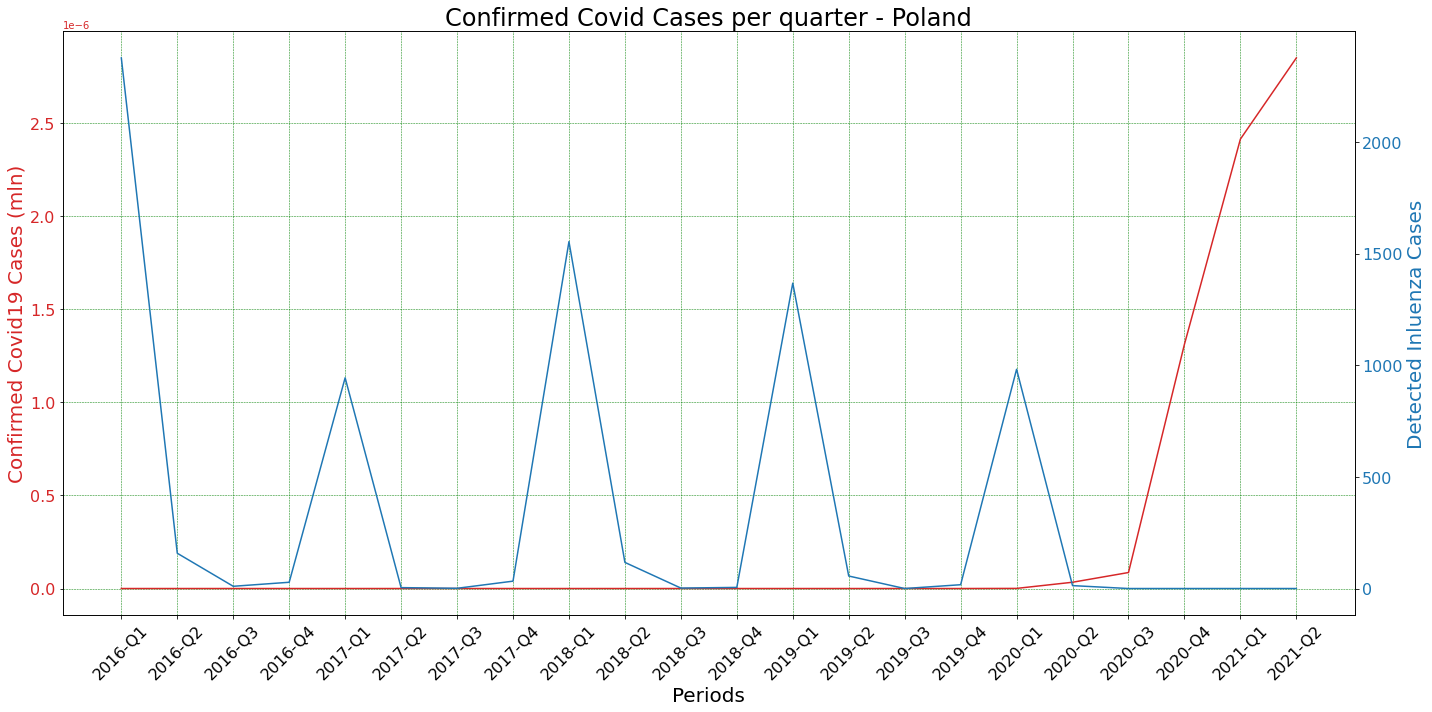

In [161]:
chart = final_df_grouped_country.copy()
chart['YearQuater'] = chart.Year.astype(str)+'-Q'+chart.Quarter.astype(str)
chart = chart.drop(["Year","Quarter"],axis=1)

chart = CovidCasesDevider(chart)

fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = (20,10)
plt.xticks(fontsize=16, rotation=45)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

y = chart['Confirmed_(mln)']
x = chart.YearQuater.unique()
z = chart.Detected_FluCases

ax1.set_title(f'Confirmed Covid Cases per quarter - {chosen_country}', fontsize=24)

color = 'tab:red'
ax1.set_xlabel('Periods', fontsize=20)
ax1.set_ylabel('Confirmed Covid19 Cases (mln)', color=color, fontsize=20)
ax1.plot(x, y, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize = 16)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Detected Inluenza Cases', color=color, fontsize=20)  # we already handled the x-label with ax1
ax2.plot(x, z, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize = 16)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()